# Broadband Simulations with a Waveguide Splitter

One important advantage behind FDTD simulations (compared with frequency domain simulations) is the ability to simulate a broad band of frequencies with a single run. The same holds true with the adjoint solver. In this tutorial, we'll demonstrate how we can optimize over objective functions with multiple objective quantities *and* multiple frequencies. 

We can specify the desired frequency profile in the objective function itself (like with many curve-fitting algorithms), or we can instead opt to perform an epigraph formulation on the equivalent minimax functional, which requires gradients for each parameter at each frequency point of interest. We'll quickly see that the adjoint solver provides a seamless interface to all of these features.

In [1]:
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
import numpy as np
from matplotlib import pyplot as plt
import nlopt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


We'll begin by building a simple (and somewhat impractical) waveguide splitter that will require multiple objective quantities in the objective function definition.

In [2]:
resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1.5,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)
Nx = 10
Ny = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
basis = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, mp.inf, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=basis.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    resolution=resolution)

We'll specify three eigenmode monitors: one to measure the total input power and one to measure the power in each arm. 

Notice that the bottom monitor has an extra parameter: `forward=False`. This is indicating the directionality of the eigenmode monitor. Since we want to track modes propogating down (rather than the default up) we must set this flag. It essentially reverses all of our forward and backward propogating coefficients and helps the adjoint solver determine which direction to inject the adjoint source.

In [3]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-1),size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=1.5)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,-1,0),size=mp.Vector3(x=1.5)),mode,forward=False)
ob_list = [TE0,TE_top,TE_bottom]

We want our splitter to demonstrate a uniform frequency response across our band of interest. We can enforce this constraint in our objective function. We'll calculate the mean squared error between the desired band (1) and the sum of our top and bottom waveguide transmission spectra for the fundamental mode. 

Our objective function can be as complicated as we want, so long as we use `autograd`'s version of numpy.

In [4]:
def J(source,top,bottom):
    desired_profile = 0.5
    top_mse = npa.mean(npa.abs(desired_profile - npa.abs(top/source) ** 2) ** 2)
    bottom_mse = npa.mean(npa.abs(desired_profile - npa.abs(bottom/source) ** 2) ** 2)
    return top_mse + bottom_mse

As before, we will generate our adjoint solver object. This time, however, we'll be sure to include the number of frequency points we care about, as well as the bandwidth of our objective function (the same as our source in this case).

In [5]:
nf = 100 # number of frequency points to simulate
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_function = J,
    objective_arguments = ob_list,
    basis = [basis],
    fcen = fcen,
    df = fwidth,
    nf = nf,
    decay_fields=[mp.Ez]
)

If we visualize our results we should see all three monitors and the source term.

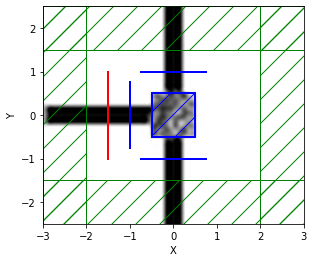

In [6]:
opt.plot2D(True)
plt.show()

Before we perform our optimization, let's examine the shape of our gradient after one iteration:

In [7]:
f0, dJ_deps, dg = opt([rho_vector])
print(dJ_deps[0].shape)

Starting forward run...
Starting adjoint run...
Calculating gradient...
(12, 12, 1, 100)


We note that the gradient returns a numpy array with an extra dimension corresponding to the number of frequency points (Nx,Ny,Nz,Nf). In other words, the adjoint solver calculates the gradient at every spatial point *and* every frequency point. This is especially useful for minimax formulations, as we'll see later.

For now, we need to figure out what to do with all these gradients! This may seem like extra work at first, but in fact offers tremendous flexibility. For example, since we have access to these gradients, we can optimize of dispersive materials too!

In this tutorial, however, we'll keep things simple and remember than our material is not dispersive. Consequently, from the chain rule and the definition of the adjoint, we realize we can just add up all the gradients along the frequency axis. We can either do this before or after the vector jacobian product of the interpolator (the sum of the transform is the same as the transform of the sum). However the VJP method always assumes at least one frequency point. To keep our numpy array axes simple, we'll sum the final design parameters over frequency.

Remember, you can always check your final gradient with a finite difference approximate if you are worried about accuracy!

For now, we'll incorporate this important fact into our wrapped objective function needed by `nlopt`.

In [8]:
evaluation_history = []
def f(x, grad):
    f0, dJ_deps, dg = opt([x])
    if grad.size > 0:
        grad[:] = np.sum(basis.get_basis_vjp(dJ_deps[0],dg[0]),axis=1)
    evaluation_history.append(np.real(f0))
    return np.real(f0)

Once again we'll opt to use the Method of Moving Asymptotes. This time, however, we'll *minimize* our functional, since the objective function describes the *error* of the system.

In [9]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 20

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(1)
solver.set_upper_bounds(12)
solver.set_min_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(rho_vector)

[11.56019034  8.69463255 11.99854022  3.4207403   4.97161989  9.13825089
 11.96101298  4.47981676  2.50199038  5.22378011  4.52571212  5.03056228
  8.80616719 10.90156674  6.87526983  3.72023141  8.38987219  7.17902018
  6.96815864 10.82792364 10.27057505  4.36613849  7.94286755  8.48262746
 11.67470316 10.82923867 11.36668447  8.06448029  7.76112397  3.5045158
  6.34635056  9.87941229 10.28642169  6.88148953  9.33577855  6.49644575
 10.35360686  7.81666453 10.47775597  3.54866916  5.42440256  7.86812568
  2.57340376  2.35078332  5.58512902  7.1257128  11.35561093  5.50184925
  9.10426594 11.94995742 11.08330784  1.022256   11.68464863 10.77952994
  8.69437467  2.07277135  7.30771943 10.02040828  7.16980156  4.85838707
  6.97849732 10.67548001  2.25506221  1.34582686 11.48091066  4.17617822
  5.86144088  3.84923685  7.56580588  8.20814651  4.03265007 10.43769704
 10.77596561  4.1356665   8.25516461 11.69332285  9.76561524  2.97410841
  9.63140276 11.67140677  4.99092946  1.96674671  4.

Notice that the adjoint simulation takes slightly longer than the forward simulation. This is because our original cost function incorporates multible objective arguments over multiple frequency points. Consequently, Meep has to estimate the correct adjoint source time profile that satisfies these requirements. Denser frequency grids correspond to longer time profiles that naturally take longer to turn off.

That being said, the cost of simulating one extra frequency point this way is marginal compared to the cost of an entirely new frequency domain simulation.

We can easily plot our history and ensure that the cost truly minimizes.

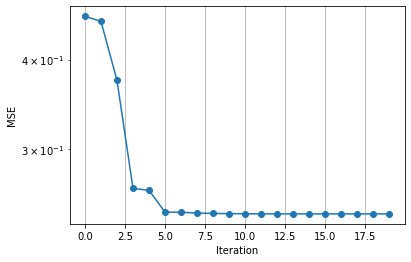

In [10]:
plt.figure()
plt.semilogy(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

This cost functional is somewhat opaque -- it's hard to tell how well our device truly operates. It's best to examine the transmission spectra for each of the arms directly.

Luckily, we can use our existing solver object to run a simple forward simulation (and just a forward simulation) using the "optimum" parameters and subsequently pull the requested eigenmode coefficients. From these we can quickly calculate the transmission responses for each arm.

In [11]:
f0, dJ_deps, dg = opt([x],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

Starting forward run...


We can visualize each frequency profile for the two arms.

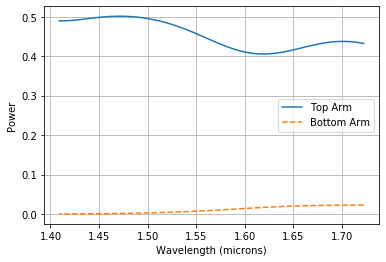

In [12]:
plt.figure()
plt.plot(1/frequencies,top_profile,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile,'--',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power')
plt.show()

We see that the top arm is relatively constant across the band, but the bottom arm exhibits particularly poor performance. Furthermore, the cost function appears to have hit a local minima -- a common and difficult problem in nonconvex optimization.

We'll approach our problem from a different approach. This time, let's minimize the maximum error for each frequency point:

$$
J = \textrm{max}[(0.5 - P_{top}(f))^2 + (0.5 - P_{bottom}(f))^2]
$$

Which is a minimax problem. We can reframe our minimax problem using the epigraph formulation. To do so, we'll slightly modify our objective functional to be *multivalued*. We'll incorporate each output as a constraint bounded by a dummy variable $t$. More information behind this technique can be found [here](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/#equivalent-formulations-of-optimization-problems).

Ideally, we would separate each arm into it's own functional and and each of them into our bank of objective functions. Unfortunately, this would require additional forward and adjoint simulations -- an important caveat to the adjoint solver (and reverse-mode differentiation in general) is that it can produce an entire row of the jacobian, but not the entire matrix. We are able to get multiple rows for each frequency point because of some fancy postprocessing.

In [13]:
def J(source,top,bottom):
    desired_profile = 0.5
    top_mse = npa.abs(desired_profile - npa.abs(top/source) ** 2) ** 2
    bottom_mse = npa.abs(desired_profile - npa.abs(bottom/source) ** 2) ** 2
    return top_mse + bottom_mse

We can now formulate our cost function with our dummy variable $t$ used by `nlopt`.

In [14]:
evaluation_history = []
def f(x, grad):
    t = x[0]
    v = x[1:]
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

Next, we'll add vector-valued nonlinear constraints using the Jacobian provided by meep.

In [15]:
def c(result,x,grad):
    t = x[0]
    v = x[1:]
    f0, dJ_deps, dg = opt([v])
    if grad.size > 0:
        grad[:,0] = 0 # gradient w.r.t. "t"
        grad[:,1:] = basis.get_basis_vjp(dJ_deps[0],dg[0]).transpose() # gradient w.r.t. "rho"
    evaluation_history.append(np.max(np.real(f0)))
    result[:] = np.real(f0) - t

As before, we'll define our optimizer object and add all of our constraints.

In [16]:
maxeval = 30
algorithm = nlopt.LD_MMA
solver = nlopt.opt(algorithm, Nx*Ny+1)
solver.set_min_objective(f)
solver.add_inequality_mconstraint(c, np.array([1e-4]*Nx*Ny))
solver.set_lower_bounds(np.array([0] + [1]*Nx*Ny))
solver.set_upper_bounds(12)
solver.set_maxeval(maxeval)
x0 = np.array([1] + rho_vector.tolist())
x = solver.optimize(x0)

[ 1.         11.56019034  8.69463255 11.99854022  3.4207403   4.97161989
  9.13825089 11.96101298  4.47981676  2.50199038  5.22378011  4.52571212
  5.03056228  8.80616719 10.90156674  6.87526983  3.72023141  8.38987219
  7.17902018  6.96815864 10.82792364 10.27057505  4.36613849  7.94286755
  8.48262746 11.67470316 10.82923867 11.36668447  8.06448029  7.76112397
  3.5045158   6.34635056  9.87941229 10.28642169  6.88148953  9.33577855
  6.49644575 10.35360686  7.81666453 10.47775597  3.54866916  5.42440256
  7.86812568  2.57340376  2.35078332  5.58512902  7.1257128  11.35561093
  5.50184925  9.10426594 11.94995742 11.08330784  1.022256   11.68464863
 10.77952994  8.69437467  2.07277135  7.30771943 10.02040828  7.16980156
  4.85838707  6.97849732 10.67548001  2.25506221  1.34582686 11.48091066
  4.17617822  5.86144088  3.84923685  7.56580588  8.20814651  4.03265007
 10.43769704 10.77596561  4.1356665   8.25516461 11.69332285  9.76561524
  2.97410841  9.63140276 11.67140677  4.99092946  1

We can tack our progress

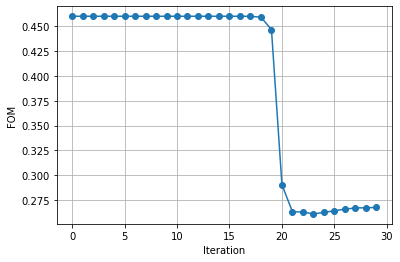

In [17]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

And visualize the "optimized" structure.

In [18]:
f0, dJ_deps, dg = opt([x],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

Starting forward run...


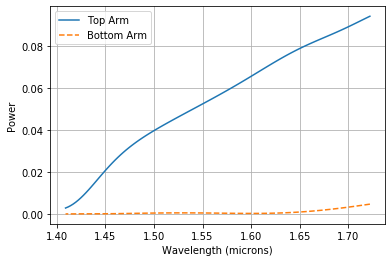

In [19]:
plt.figure()
plt.plot(1/frequencies,top_profile,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile,'--',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power')
plt.show()

Unfortunately, the device performs rather poorly. We can quickly visualize the final device:

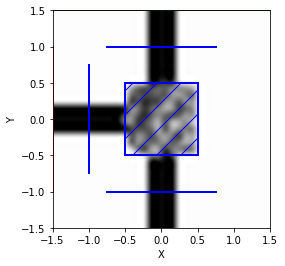

In [20]:
opt.update_design([x])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()

As sophisticated as the methods are, we quickly see that optimization is a difficult game that requires iteration and creativity. For example, in this problem, we should implement symmetry constraints and start with an initial parameter set we expect to behave well.

Regardless, meep's adjoint solver is capable of leveraging it's inherit broadband functionality to optimize a wide range of objective function formulations.